#  Vasicek Model

https://en.wikipedia.org/wiki/Vasicek_model

[*********************100%***********************]  1 of 1 completed
Calibrated Vasicek model parameters - kappa: 0.09999999873459399, theta: 0.029999995328201683, sigma: 0.04999999847672509


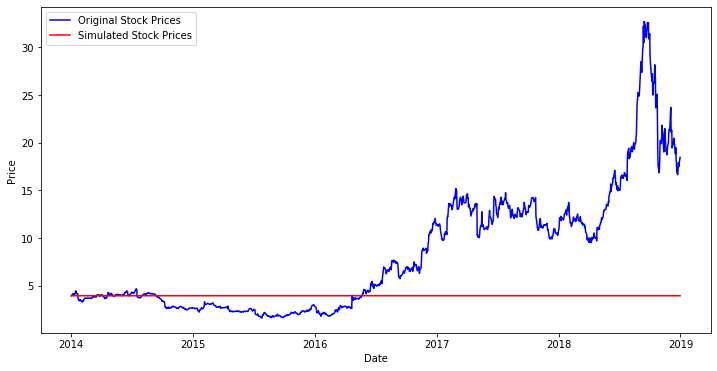

In [1]:
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# input
symbol = 'AMD'
start = '2014-01-01'
end = '2019-01-01'

# Read data
dataset = yf.download(symbol, start, end)

# Prepare data
data = dataset['Adj Close']

# Define the Vasicek model
def vasicek(r, kappa, theta, sigma, dt, num_paths=1):
    r_t = np.zeros((num_paths, len(r)))  # Modify to have the same shape as data
    dW = np.random.normal(0, np.sqrt(dt), (num_paths, len(r)))

    for i in range(1, len(r)):
        dr = kappa * (theta - r_t[:, i-1]) * dt + sigma * np.sqrt(dt) * dW[:, i]
        r_t[:, i] = r_t[:, i-1] + dr

    return r_t

# Estimate Vasicek model parameters
def vasicek_calibration(data):
    def mean_squared_error(params):
        kappa, theta, sigma = params
        dt = 1/252  # Daily data
        r = data.pct_change().dropna().values
        r_pred = vasicek(r, kappa, theta, sigma, dt)
        return np.mean((r - r_pred[0])**2)  # Use r_pred[0] for the comparison

    result = minimize(mean_squared_error, [0.1, 0.03, 0.05], method='L-BFGS-B')
    kappa, theta, sigma = result.x
    return kappa, theta, sigma

kappa, theta, sigma = vasicek_calibration(data)
print(f"Calibrated Vasicek model parameters - kappa: {kappa}, theta: {theta}, sigma: {sigma}")

# Simulate interest rates using Vasicek model
dt = 1/252  # Daily data
num_paths = 1
r0 = data.pct_change().dropna().values[-1]  # Initial rate
num_days = len(data)
r_simulated = vasicek(np.array([r0]), kappa, theta, sigma, dt, num_paths=num_days)

# Convert interest rates to stock prices
stock_prices = np.cumprod(1 + r_simulated)
stock_prices = data.values[0] * stock_prices[0]  # Use stock_prices[0] to match dimensions

# Set the same index for stock_prices as data
stock_prices = pd.Series(stock_prices, index=data.index)

# Plot the original stock prices and simulated prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data.values, label='Original Stock Prices', color='blue')
plt.plot(stock_prices.index, stock_prices.values, label='Simulated Stock Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

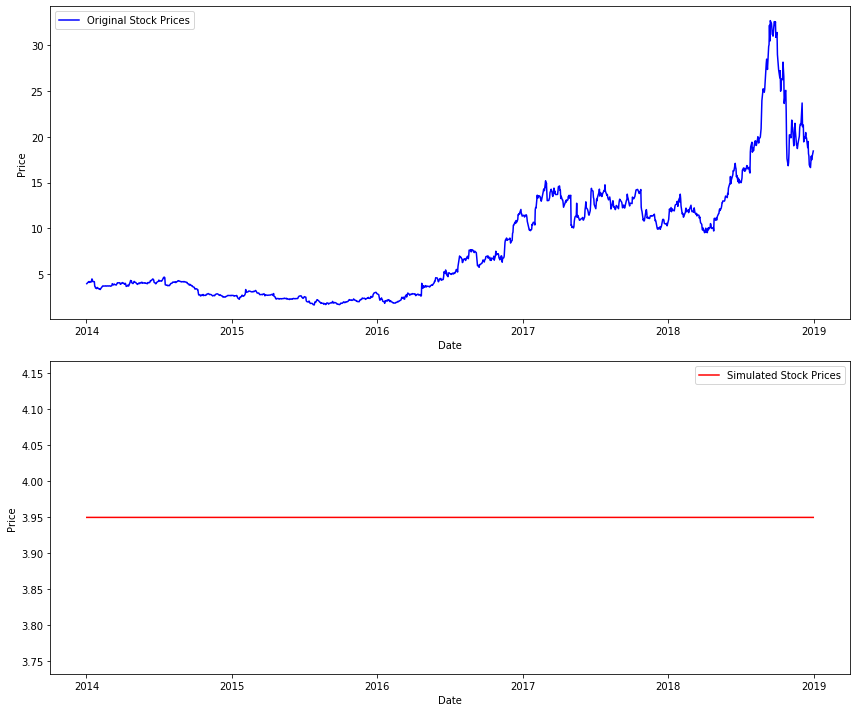

In [2]:
# Create two separate subplots for original and simulated stock prices
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Original Stock Prices
ax1.plot(data.index, data.values, label='Original Stock Prices', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()

# Simulated Stock Prices
ax2.plot(stock_prices.index, stock_prices.values, label='Simulated Stock Prices', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.legend()

plt.tight_layout()
plt.show()